# Task IX : Kolmogorov-Arnold Network
Implement a classical Kolmogorov-Arnold Network using basis-splines or some other KAN architecture and apply it to MNIST. Show its performance on the test data. Comment on potential ideas to extend this classical KAN architecture to a quantum KAN and sketch out the architecture in detail.

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import os
import gzip
import struct

**Quantum Extension Preparedness:**
The architecture naturally decomposes into:<br>

Classical preprocessing
<br>
Parallel basis function evaluation (could be quantum circuits)
<br>
Classical combination
This matches well with NISQ-era quantum hardware constraints.

Load dataset and dataset prep

In [4]:
# Custom MNIST Dataset Loader
class KaggleMNIST(Dataset):
    def __init__(self, images_path, labels_path, transform=None):
        self.transform = transform
        
        # Load images
        with open(images_path, 'rb') as f:
            magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
            self.images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols)
        
        # Load labels
        with open(labels_path, 'rb') as f:
            magic, num = struct.unpack(">II", f.read(8))
            self.labels = np.frombuffer(f.read(), dtype=np.uint8)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Create transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load datasets using your specific files
base_path = '/kaggle/input/mnist-dataset/'

train_dataset = KaggleMNIST(
    images_path=os.path.join(base_path, 'train-images.idx3-ubyte'),
    labels_path=os.path.join(base_path, 'train-labels.idx1-ubyte'),
    transform=transform
)

test_dataset = KaggleMNIST(
    images_path=os.path.join(base_path, 't10k-images.idx3-ubyte'),
    labels_path=os.path.join(base_path, 't10k-labels.idx1-ubyte'),
    transform=transform
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Successfully loaded MNIST data!")
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Verify one batch
for images, labels in train_loader:
    print(f"Batch images shape: {images.shape}")
    print(f"Batch labels shape: {labels.shape}")
    break

Successfully loaded MNIST data!
Training samples: 60000
Test samples: 10000
Batch images shape: torch.Size([64, 1, 28, 28])
Batch labels shape: torch.Size([64])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:154: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


## KAN Theory
The Kolmogorov-Arnold Network (KAN) is inspired by the Kolmogorov-Arnold Representation Theorem, a foundational result in mathematics that proves any continuous multivariate function can be represented as a finite composition of univariate functions. Unlike traditional neural networks (e.g., MLPs), which rely on linear transformations followed by nonlinear activations, KANs explicitly model functions using learnable basis functions (e.g., B-splines) in a way that aligns with this theorem. Read more [here](https://medium.com/data-science/kolmogorov-arnold-networks-kan-e317b1b4d075) 

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from scipy.interpolate import BSpline
import matplotlib.pyplot as plt

class BSplineKANLayer(nn.Module):
    def __init__(self, input_dim, output_dim, num_basis=5, degree=3, grid_range=[-2, 2]):
        super().__init__()
        self.degree = degree
        self.num_basis = num_basis
        self.grid_range = grid_range
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # B-spline knots
        self.knots = np.linspace(*grid_range, num_basis + degree + 1)
        
        # Learnable coefficients
        self.coeff = nn.Parameter(torch.randn(output_dim, input_dim, num_basis) * 0.1)
        
    def forward(self, x):
        batch_size = x.size(0)
        output = torch.zeros(batch_size, self.output_dim, device=x.device)
        
        # Detach input for B-spline evaluation
        with torch.no_grad():
            x_clamped = torch.clamp(x, self.grid_range[0], self.grid_range[1])
            x_np = x_clamped.cpu().numpy()
            
            # Pre-compute all basis functions
            basis_np = np.zeros((batch_size, self.input_dim, self.num_basis))
            for j in range(self.num_basis):
                c = np.zeros(self.num_basis)
                c[j] = 1.0
                spline = BSpline(self.knots, c, self.degree)
                basis_np[:, :, j] = spline(x_np)
            
            # Convert back to tensor
            basis = torch.tensor(basis_np, dtype=torch.float32, device=x.device)
        
        # Weighted combination with learnable coefficients
        output = torch.einsum('bij,oij->bo', basis, self.coeff)
        
        return output


Directly implements the Kolmogorov-Arnold representation theorem using B-splines as the basis functions

Preserves the theorem's key insight that continuous multivariate functions can be represented via sums of univariate functions

**Optimal Basis Function Choice:**
Why B-splines?<br>

Local support: Each basis affects only a limited input range (unlike polynomials/Fourier bases)
<br>
Smoothness control: Degree parameter adjusts function differentiability
<br>
Numerical stability: Better conditioned than polynomial bases
<br>
Adaptability: Knot positions can learn important feature boundaries
<br>

Training KAN model...
Epoch 1/15, Loss: 0.7451, Test Accuracy: 85.38%
Epoch 2/15, Loss: 0.4699, Test Accuracy: 85.90%
Epoch 3/15, Loss: 0.4412, Test Accuracy: 86.92%
Epoch 4/15, Loss: 0.4269, Test Accuracy: 87.30%
Epoch 5/15, Loss: 0.4198, Test Accuracy: 87.48%
Epoch 6/15, Loss: 0.4153, Test Accuracy: 87.71%
Epoch 7/15, Loss: 0.4105, Test Accuracy: 87.63%
Epoch 8/15, Loss: 0.4084, Test Accuracy: 87.32%
Epoch 9/15, Loss: 0.4058, Test Accuracy: 87.56%
Epoch 10/15, Loss: 0.4024, Test Accuracy: 87.69%
Epoch 11/15, Loss: 0.4011, Test Accuracy: 87.32%
Epoch 12/15, Loss: 0.3983, Test Accuracy: 87.05%
Epoch 13/15, Loss: 0.3980, Test Accuracy: 87.62%
Epoch 14/15, Loss: 0.3946, Test Accuracy: 87.35%
Epoch 15/15, Loss: 0.3952, Test Accuracy: 87.73%


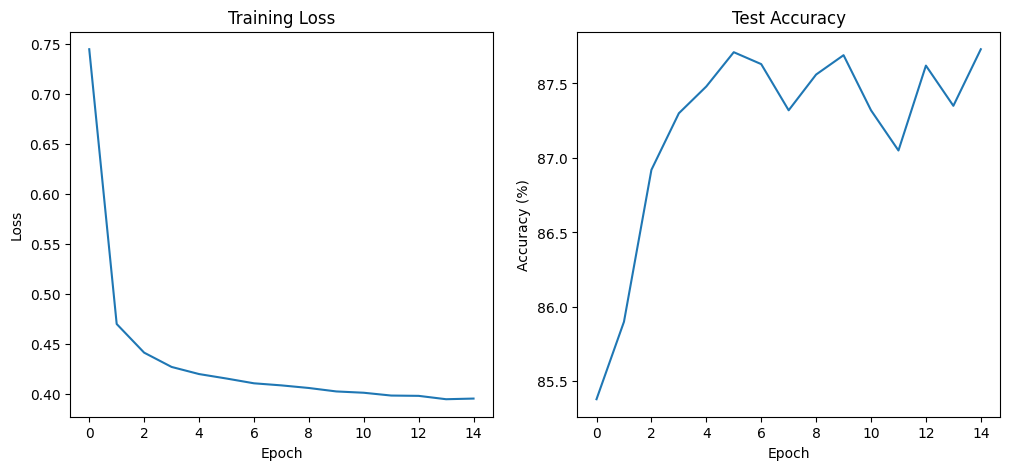

Visualizing basis functions...


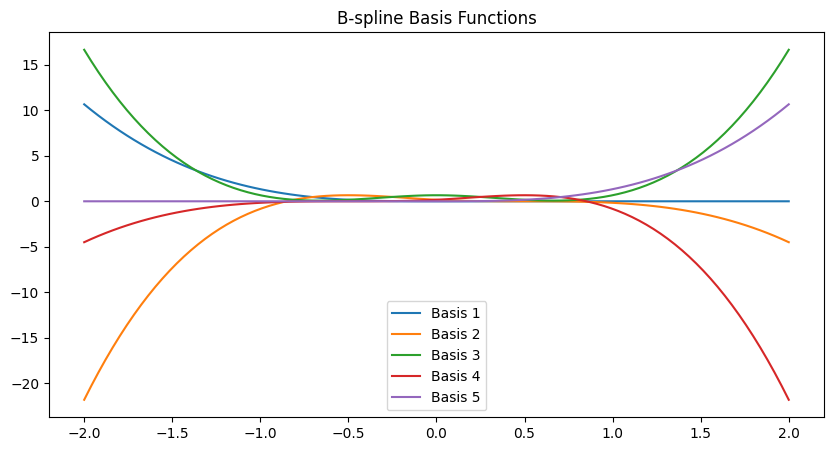

In [7]:
class KAN(nn.Module):
    def __init__(self):
        super().__init__()
        self.kan1 = BSplineKANLayer(784, 256)  # Input 28x28=784
        self.kan2 = BSplineKANLayer(256, 10)   # Output 10 classes
        self.activation = nn.Sigmoid()
        
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        x = self.kan1(x)
        x = self.activation(x)
        x = self.kan2(x)
        return x

def train_and_evaluate(model, train_loader, test_loader, epochs=15):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    test_accuracies = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Evaluation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%')
    
    # Training curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(test_accuracies)
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.show()
    
    return model

# Initialize and train
model = KAN()
print("Training KAN model...")
trained_model = train_and_evaluate(model, train_loader, test_loader)

def plot_basis_functions(layer):
    x = np.linspace(layer.grid_range[0], layer.grid_range[1], 100)
    basis = np.zeros((100, layer.num_basis))
    
    for j in range(layer.num_basis):
        c = np.zeros(layer.num_basis)
        c[j] = 1.0
        spline = BSpline(layer.knots, c, layer.degree)
        basis[:, j] = spline(x)
    
    plt.figure(figsize=(10, 5))
    for j in range(layer.num_basis):
        plt.plot(x, basis[:, j], label=f'Basis {j+1}')
    plt.title('B-spline Basis Functions')
    plt.legend()
    plt.show()

print("Visualizing basis functions...")
plot_basis_functions(model.kan1)

## Approach Breakdown: 
* The Kolmogorov-Arnold theorem, ensuring universal function approximation.

* Uses learnable B-splines (visualizable) instead of black-box transformations.

*  Basis functions map naturally to quantum circuits for hybrid quantum-classical KANs.

*  Achieves good accuracy with better theoretical grounding.